In [1]:
import os
import copy
import glob
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import Dataset

from ipywidgets import interact
import ipywidgets as widgets


In [2]:
ROOT_DIR = "D:/PATH/Python/4Geeks/Proyecto_Final_Cancer"
SCORE_PATH = "../data/raw/ISIC_2024_Challenge_SelfClean_Scores.csv"
ND_PATH = "../data/raw/ISIC_2024_Challenge_SelfClean_Near_Duplicates.csv"
TRAIN_DIR = "data/image"
DATA_PATH = "../data/raw/train-metadata.csv"

In [15]:
df = pd.read_csv(DATA_PATH)

C:\Users\rakus\AppData\Local\Temp\ipykernel_11416\2144582446.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


In [5]:
df_scores = pd.read_csv(SCORE_PATH)

In [ ]:
df_scores.drop(columns=['irrelevant_ranking', 'label_error_ranking'], inplace=True)
df_scores.head(5)

In [17]:
class ISICDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.file_names = df["file_path"].values
        self.targets = df["target"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        img_path = self.file_names[index]
        target = self.targets[index]

        img = Image.open(img_path)
        img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, int(target)

In [18]:
train_dir = Path(ROOT_DIR) / TRAIN_DIR

train_images = sorted(glob.glob(f"{train_dir}/*.jpg"))

In [20]:
df["file_path"] = df["isic_id"].apply(
    lambda image_id: str(Path(train_dir) / f"{image_id}.jpg")
)
print(df["file_path"].head())  # Check the first few file paths generated in df
train_images[:5]        # Check the first few file paths in train_images
df = df[df["file_path"].isin(train_images)].reset_index(drop=True)

df['target_name'] = df['target'].replace(0, 'Benign').replace(1, 'Malignant')

dataset = ISICDataset(df=df)
df.head()

0    D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...
1    D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...
2    D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...
3    D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...
4    D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...
Name: file_path, dtype: object


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path,target_name
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign


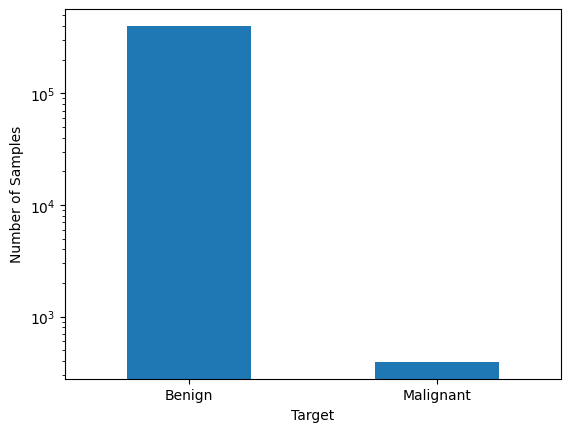

In [23]:
df["target_name"].value_counts().plot.bar(logy=True)
plt.xticks(rotation=0)
plt.ylabel("Number of Samples")
plt.xlabel("Target")
plt.show()

C:\Users\rakus\AppData\Local\Temp\ipykernel_11416\3673277204.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


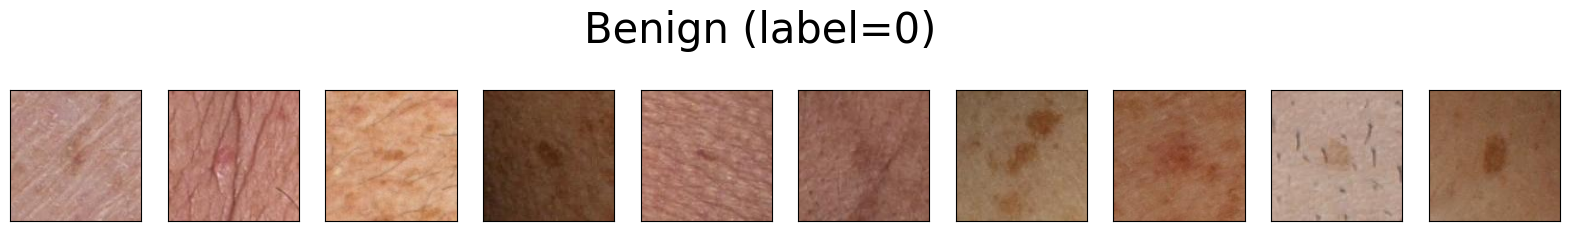

In [24]:
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
for i, (_, row) in enumerate(df[df["target"] == 0][:10].iterrows()):
    ax[i].imshow(Image.open(row["file_path"]))
    ax[i].set_yticks([])
    ax[i].set_xticks([])
fig.suptitle("Benign (label=0)", fontsize=30)
fig.show()

C:\Users\rakus\AppData\Local\Temp\ipykernel_11416\307979474.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


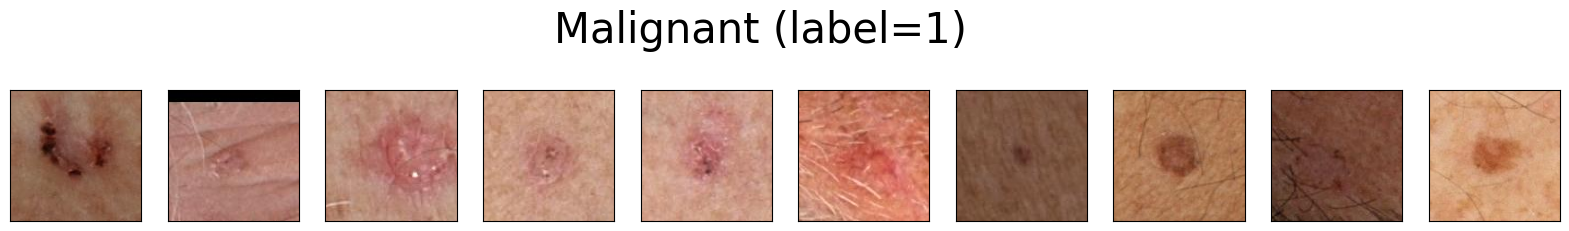

In [25]:
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
for i, (_, row) in enumerate(df[df["target"] == 1][:10].iterrows()):
    ax[i].imshow(Image.open(row["file_path"]))
    ax[i].set_yticks([])
    ax[i].set_xticks([])
fig.suptitle("Malignant (label=1)", fontsize=30)
fig.show()

In [21]:
df = df.merge(df_scores, on=["isic_id", "patient_id"])
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path,target_name,img_name,irrelevant_score,label_error_score
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,NaN,NaN,NaN,97.517282,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign,ISIC_0015670,0.998226,0.932858
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,NaN,NaN,NaN,NaN,3.141455,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign,ISIC_0015845,0.996162,0.749375
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,NaN,NaN,NaN,99.804040,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign,ISIC_0015864,0.998182,0.975466
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,NaN,NaN,NaN,99.989998,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign,ISIC_0015902,0.998253,0.994378
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,NaN,NaN,NaN,70.442510,D:\PATH\Python\4Geeks\Proyecto_Final_Cancer\da...,Benign,ISIC_0024200,0.997726,0.895673


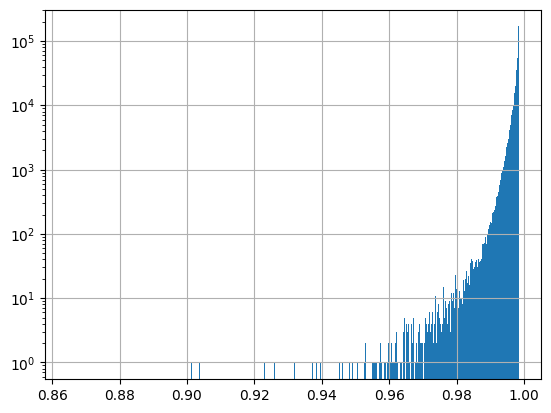

In [22]:
df["irrelevant_score"].hist(bins="sqrt")
plt.yscale("log")
plt.show()


In [28]:
@interact(
    start_index = widgets.IntSlider(min=0, max=10_000, step=10, value=0)
)
def show_irrelevant_samples(start_index: int):
    n_samples: int = 10
    end_index = start_index+n_samples
    fig, ax = plt.subplots(1, n_samples, figsize=(20, 3))
    for i, (_, row) in enumerate(df.sort_values("irrelevant_score")[start_index:end_index].iterrows()):
        ax[i].imshow(Image.open(row["file_path"]))
        ax[i].set_yticks([])
        ax[i].set_xticks([])
    fig.suptitle(f"Irrelevant Samples {start_index+1}-{end_index}", fontsize=30)
    fig.show()

interactive(children=(IntSlider(value=0, description='start_index', max=10000, step=10), Output()), _dom_class…

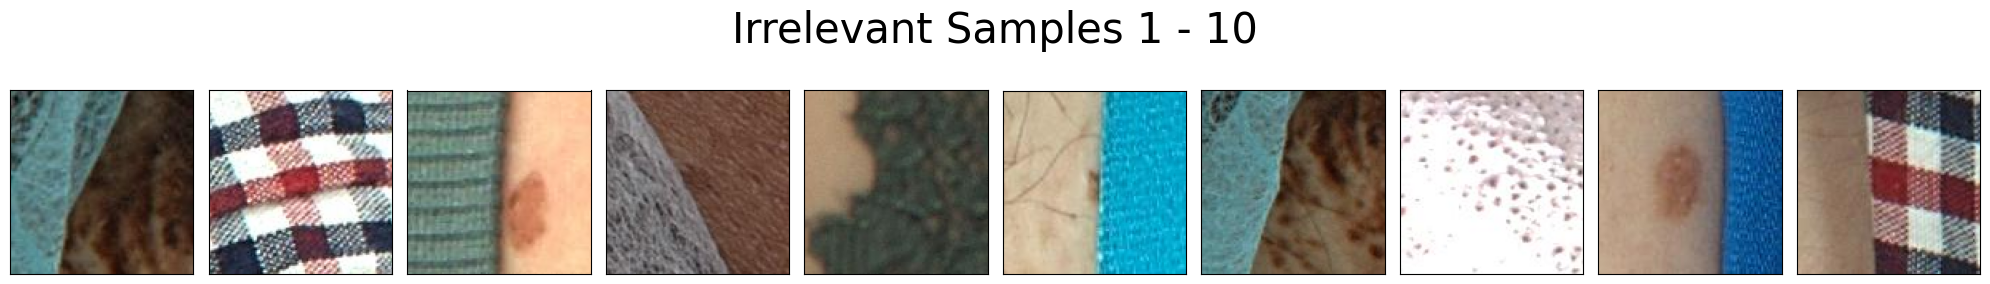

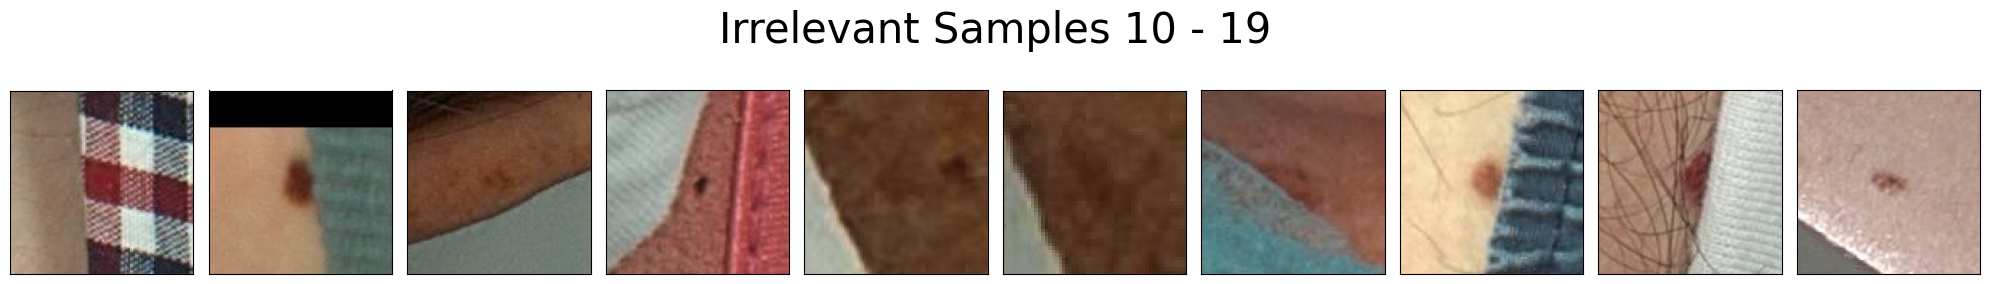

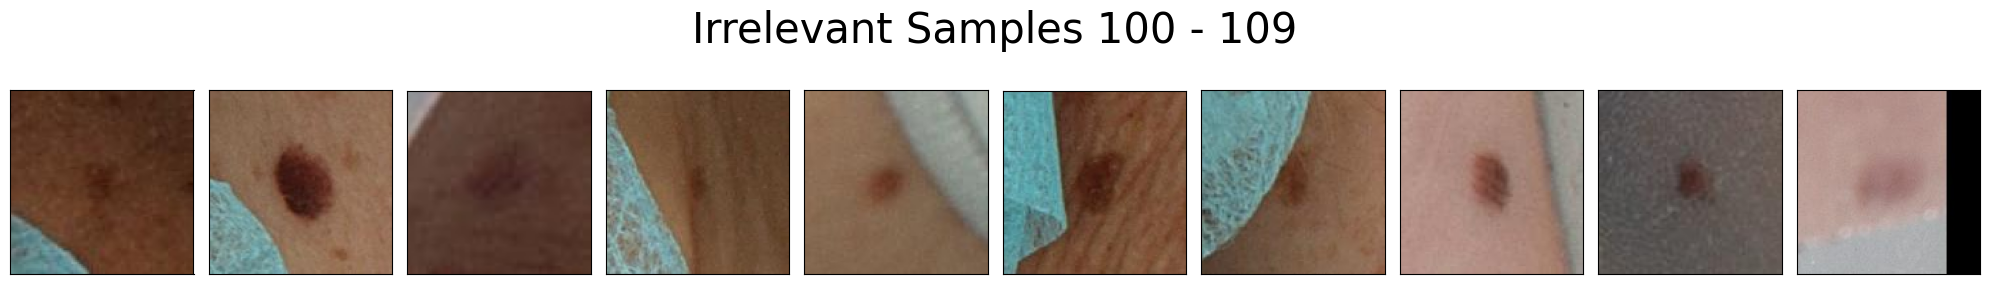

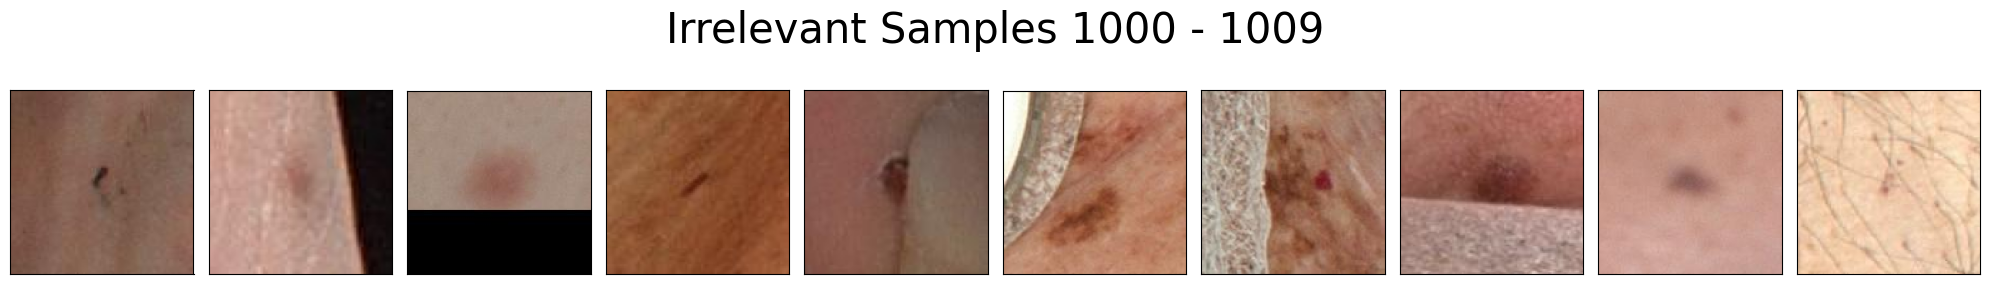

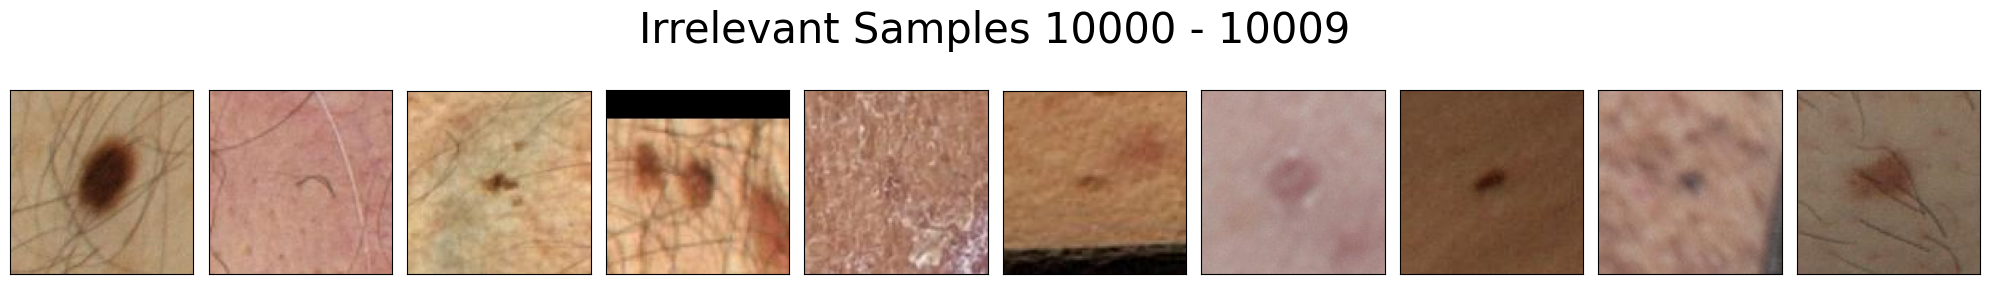

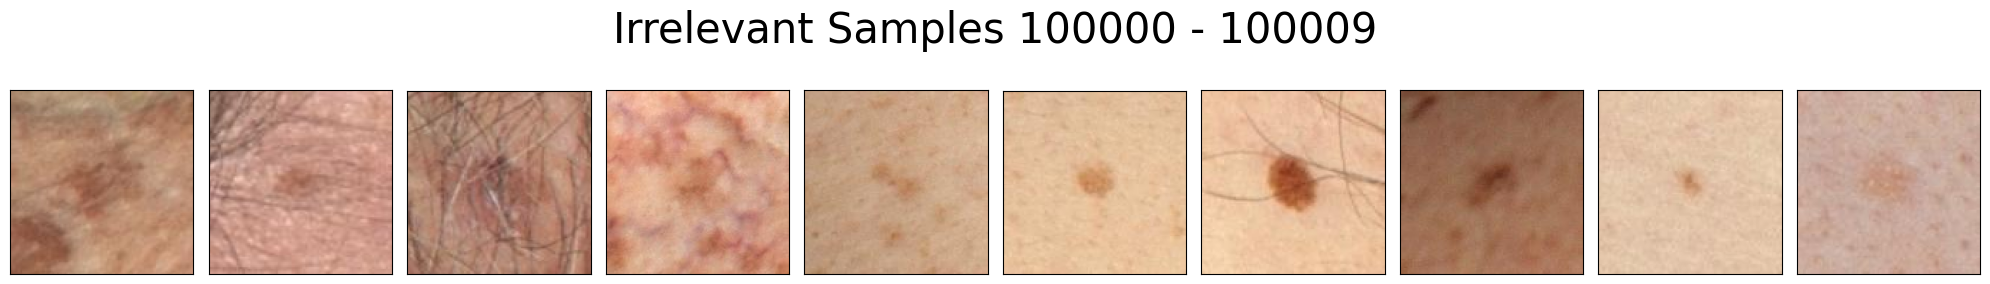

In [27]:
sorted_df = df.sort_values(by="irrelevant_score")
for i in range(6):
    n_skip = 10**i - 1
    fig, axes = plt.subplots(1, 10, figsize=(20, 3))
    for i, ax in enumerate(axes):
        idx = sorted_df.iloc[n_skip + i].name
        ax.imshow(dataset[idx][0])
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f"Irrelevant Samples {n_skip+1} - {n_skip+10}", fontsize=30)
    fig.tight_layout()
    plt.show()


### NEAR DUPLICATES

In [30]:
df_nd = pd.read_csv(ND_PATH)
df_nd.head()

,nn_idx_0,nn_sim_0,nn_idx_1,nn_sim_1,nn_idx_10,nn_sim_10,nn_idx_11,nn_sim_11,nn_idx_12,nn_sim_12,...,nn_idx_95,nn_sim_95,nn_idx_96,nn_sim_96,nn_idx_97,nn_sim_97,nn_idx_98,nn_sim_98,nn_idx_99,nn_sim_99
0,ISIC_2927594,1.000000,ISIC_2778283,0.876176,ISIC_9695337,0.812795,ISIC_8200761,0.808804,ISIC_4182807,0.807656,...,ISIC_8420622,0.731170,ISIC_9053321,0.731050,ISIC_3329349,0.730885,ISIC_1858563,0.730698,ISIC_0884617,0.729868
1,ISIC_6973333,1.000000,ISIC_1725130,0.962918,ISIC_7767328,0.944253,ISIC_5521233,0.943567,ISIC_4414349,0.942979,...,ISIC_3227207,0.922722,ISIC_1714304,0.922681,ISIC_2449859,0.922452,ISIC_4049006,0.922417,ISIC_0336667,0.922370
2,ISIC_4195874,1.000001,ISIC_9314645,0.922684,ISIC_3434514,0.901206,ISIC_1151979,0.896634,ISIC_2956971,0.895345,...,ISIC_0819066,0.840393,ISIC_2910632,0.840171,ISIC_5228931,0.839991,ISIC_3838112,0.839671,ISIC_9344456,0.838741
3,ISIC_8416011,1.000000,ISIC_3021221,0.878384,ISIC_8544063,0.855027,ISIC_8286698,0.853880,ISIC_2365532,0.853331,...,ISIC_3187912,0.813641,ISIC_8706400,0.813562,ISIC_7430779,0.812974,ISIC_2337869,0.812858,ISIC_4444075,0.812534
4,ISIC_2307057,1.000000,ISIC_4949059,0.946690,ISIC_7660191,0.932604,ISIC_5852826,0.931590,ISIC_6635262,0.931134,...,ISIC_3395464,0.884088,ISIC_8996530,0.883728,ISIC_5857584,0.883613,ISIC_8225986,0.883344,ISIC_1082826,0.882650


In [31]:
df_nd[df_nd['nn_sim_1'] > 0.99].sort_values(by='nn_sim_1', ascending=False)


,nn_idx_0,nn_sim_0,nn_idx_1,nn_sim_1,nn_idx_10,nn_sim_10,nn_idx_11,nn_sim_11,nn_idx_12,nn_sim_12,...,nn_idx_95,nn_sim_95,nn_idx_96,nn_sim_96,nn_idx_97,nn_sim_97,nn_idx_98,nn_sim_98,nn_idx_99,nn_sim_99
216991,ISIC_3163623,1.0,ISIC_9310631,0.997207,ISIC_0621560,0.934310,ISIC_5576944,0.933551,ISIC_1193146,0.932774,...,ISIC_2552719,0.903570,ISIC_9214931,0.903331,ISIC_1632618,0.903085,ISIC_6845148,0.903056,ISIC_4045797,0.902757
223724,ISIC_9310631,1.0,ISIC_3163623,0.997207,ISIC_1193146,0.930219,ISIC_8696418,0.929848,ISIC_5576944,0.929685,...,ISIC_8962084,0.899022,ISIC_3571705,0.898894,ISIC_1632618,0.898359,ISIC_5561049,0.898266,ISIC_2117546,0.898149
217197,ISIC_5071449,1.0,ISIC_6368584,0.995644,ISIC_3940672,0.873437,ISIC_5996175,0.873343,ISIC_5335168,0.873072,...,ISIC_7483948,0.818809,ISIC_1451932,0.818580,ISIC_9808558,0.818258,ISIC_2067796,0.818231,ISIC_3252910,0.817821
328806,ISIC_6368584,1.0,ISIC_5071449,0.995644,ISIC_9764548,0.875152,ISIC_3940672,0.873319,ISIC_7539285,0.871306,...,ISIC_8887293,0.819522,ISIC_6045747,0.818652,ISIC_7785466,0.818288,ISIC_0218599,0.817481,ISIC_7802372,0.817053
307356,ISIC_9149147,1.0,ISIC_4453481,0.995493,ISIC_1001794,0.871784,ISIC_1820205,0.868766,ISIC_3265228,0.868361,...,ISIC_9156032,0.806670,ISIC_5603385,0.806508,ISIC_1305796,0.805864,ISIC_6033991,0.805756,ISIC_5381958,0.805592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271115,ISIC_8666641,1.0,ISIC_1572475,0.990262,ISIC_6415711,0.977723,ISIC_1823846,0.976688,ISIC_2472162,0.975785,...,ISIC_2518872,0.937477,ISIC_8435233,0.937432,ISIC_2823953,0.937326,ISIC_8108636,0.936374,ISIC_6822850,0.936351
38418,ISIC_4192492,1.0,ISIC_8058295,0.990142,ISIC_3340771,0.915808,ISIC_0277670,0.915224,ISIC_9793989,0.911755,...,ISIC_2830247,0.863182,ISIC_2661911,0.862480,ISIC_8045435,0.861456,ISIC_3697751,0.861288,ISIC_4549925,0.860493
103429,ISIC_8058295,1.0,ISIC_4192492,0.990142,ISIC_3209007,0.913849,ISIC_2730277,0.912276,ISIC_3340771,0.912010,...,ISIC_2661911,0.863888,ISIC_8134521,0.863530,ISIC_3864151,0.863418,ISIC_3339105,0.863356,ISIC_2830247,0.862781
36785,ISIC_7650918,1.0,ISIC_2793369,0.990097,ISIC_8575174,0.969227,ISIC_8510709,0.969176,ISIC_2597719,0.968720,...,ISIC_9704287,0.934044,ISIC_0731499,0.933999,ISIC_2950296,0.933445,ISIC_5433080,0.933166,ISIC_4101609,0.932934


C:\Users\rakus\AppData\Local\Temp\ipykernel_11416\1599043917.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


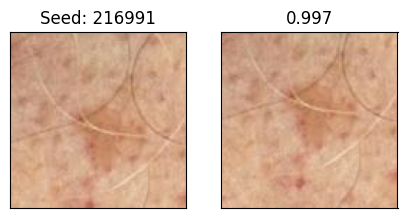

In [32]:
index = 216991
row = df_nd.iloc[index]

fig, axes = plt.subplots(1, 2, figsize=(5, 3))
for i, ax in enumerate(axes):
    image_id = row[f'nn_idx_{i}']
    sim = row[f'nn_sim_{i}']
    image = Image.open(df[df['isic_id'] == image_id]['file_path'].iloc[0])
    ax.imshow(image)
    if i == 0:
        ax.set_title(f"Seed: {index}")
    else:
        ax.set_title(f"{sim:.3f}")
    ax.set_yticks([])
    ax.set_xticks([])
fig.show()

In [33]:
df_nd.sort_values(by='nn_sim_9', ascending=False).head()


,nn_idx_0,nn_sim_0,nn_idx_1,nn_sim_1,nn_idx_10,nn_sim_10,nn_idx_11,nn_sim_11,nn_idx_12,nn_sim_12,...,nn_idx_95,nn_sim_95,nn_idx_96,nn_sim_96,nn_idx_97,nn_sim_97,nn_idx_98,nn_sim_98,nn_idx_99,nn_sim_99
276408,ISIC_0711331,1.0,ISIC_4833662,0.994093,ISIC_8947000,0.989542,ISIC_6504280,0.988208,ISIC_0668574,0.986594,...,ISIC_6656335,0.961258,ISIC_1987490,0.961190,ISIC_8440053,0.960684,ISIC_5431637,0.960485,ISIC_8145008,0.959836
353171,ISIC_2263139,1.0,ISIC_4681022,0.991263,ISIC_5962981,0.985776,ISIC_1116050,0.985706,ISIC_8137555,0.985527,...,ISIC_4470554,0.953180,ISIC_6589314,0.953117,ISIC_5159397,0.952193,ISIC_3031958,0.951770,ISIC_1409488,0.951553
87880,ISIC_2472162,1.0,ISIC_0711331,0.990843,ISIC_8157445,0.985713,ISIC_8947000,0.985551,ISIC_7156429,0.985344,...,ISIC_2176650,0.958501,ISIC_0449755,0.958272,ISIC_2078129,0.957777,ISIC_8435233,0.956798,ISIC_6125129,0.956656
219397,ISIC_5962981,1.0,ISIC_6504280,0.994512,ISIC_7474212,0.985255,ISIC_0668574,0.985129,ISIC_8137555,0.985112,...,ISIC_0260683,0.962287,ISIC_9225752,0.961937,ISIC_7610529,0.960552,ISIC_2518872,0.960214,ISIC_5431637,0.960030
118718,ISIC_8137555,1.0,ISIC_0711331,0.993715,ISIC_5962981,0.985112,ISIC_1464484,0.985075,ISIC_2472162,0.984551,...,ISIC_2628393,0.964152,ISIC_1075916,0.964136,ISIC_1987490,0.964016,ISIC_2176650,0.963449,ISIC_9964669,0.962894


C:\Users\rakus\AppData\Local\Temp\ipykernel_11416\829617790.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


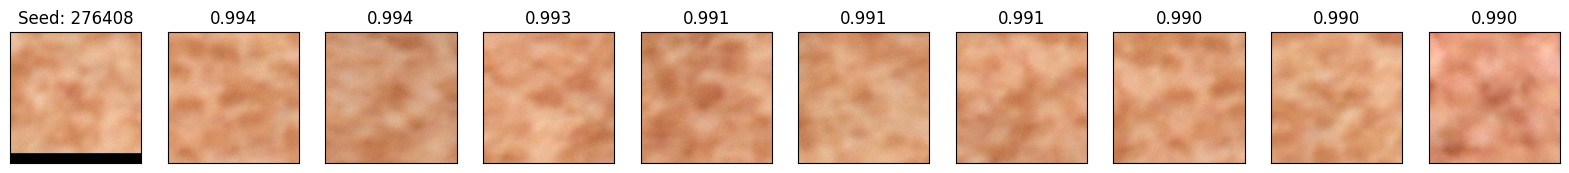

In [34]:
index = 276408
row = df_nd.iloc[index]

fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i, ax in enumerate(axes):
    image_id = row[f'nn_idx_{i}']
    sim = row[f'nn_sim_{i}']
    image = Image.open(df[df['isic_id'] == image_id]['file_path'].iloc[0])
    ax.imshow(image)
    if i == 0:
        ax.set_title(f"Seed: {index}")
    else:
        ax.set_title(f"{sim:.3f}")
    ax.set_yticks([])
    ax.set_xticks([])
fig.show()

In [ ]:
@misc{groger_selfclean_2023,
  title        = {{SelfClean}: {A} {Self}-{Supervised} {Data} {Cleaning} {Strategy}},
  shorttitle   = {{SelfClean}},
  author       = {Gröger, Fabian and Lionetti, Simone and Gottfrois, Philippe and Gonzalez-Jimenez, Alvaro and Amruthalingam, Ludovic and Consortium, Labelling and Groh, Matthew and Navarini, Alexander A. and Pouly, Marc},
  year         = 2023,
}